In [52]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from collections import defaultdict

%matplotlib inline

In [53]:
# they should be already preprocessed
def gen_match_pts(hay_img, needle_img):
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(hay_img,None)
    kp2, des2 = sift.detectAndCompute(needle_img,None)
    
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des2,des1, k=3)
    # Apply ratio test
    good = []
    for pts in matches:
        good.append([x for x in pts if x.distance < pts[0].distance * 1.3])
    matched_img = cv2.drawMatchesKnn(needle_img,kp2,hay_img,kp1,good,None,flags=2)
    plt.imshow(matched_img)
    
    # convert raw matches into dict[kp on second img] = [dmatch]
    def extract_matches(match_list_matrix, kp_1, kp_2):
        result = defaultdict(list)
        if len(match_list_matrix):
            if isinstance(match_list_matrix[0], list):
                for dmatch_list in match_list_matrix:
                    for dmatch in dmatch_list:
                        result[kp_2[dmatch.trainIdx]].append(dmatch)
            else:
                for dmatch in match_list_matrix:
                    result[kp_2[dmatch.trainIdx]].append(dmatch)
        return result
    return extract_matches(good, kp2, kp1)

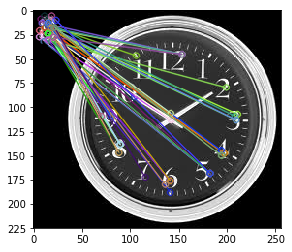

In [54]:
hay_img = 'clocks/clock2.png'
hay_img = cv2.cvtColor(cv2.imread(hay_img), cv2.COLOR_BGR2GRAY)
# _,hay_img = cv2.threshold(hay_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
hay_img = cv2.bitwise_not(hay_img)

needle_img = 'clocks/num8.png'
needle_img = cv2.cvtColor(cv2.imread(needle_img), cv2.COLOR_BGR2GRAY)
# _,needle_img = cv2.threshold(needle_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
needle_img = cv2.bitwise_not(needle_img)
macthed_kp_map = gen_match_pts(hay_img, needle_img)

In [55]:
def draw_contour_bb(img, contours=None, bbs=None, color=0):
    if contours is not None:
        bbs = [cv2.boundingRect(contour) for contour in contours]
    if bbs is None:
        raise ValueError()
    cp_img = np.copy(img)
    for x, y, w, h in bbs:
        cv2.rectangle(cp_img,(x,y),(x+w,y+h),color,1)
    plt.imshow(cp_img, cmap='gray')
    
def get_contour_bb(bw_img):
    edges = cv2.Canny(bw_img,100,200)
    im2, contours, hierarchy = cv2.findContours(edges,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    return contours

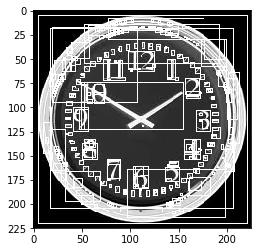

In [56]:
contours = get_contour_bb(hay_img)
draw_contour_bb(hay_img, contours, None, 255)

In [57]:
def filter_contours_by_kp(bw_img, contours, kp):
    bb_map = defaultdict(int)
    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)
        # filter out big bb, BIG ASSUMPTION
        if max(w, h) > max(bw_img.shape) / 3:
            continue
        bb_map[(x, y, w, h)] = 0
    for good_kp in kp:
        x_, y_ = good_kp.pt
        for x, y,  w, h in bb_map:
            if x_ >= x and x_ <= x + w and y_ >= y and y_ <= y + h:
                bb_map[(x, y, w, h)] += 1
    return [k for k in bb_map if bb_map[k] > 0]

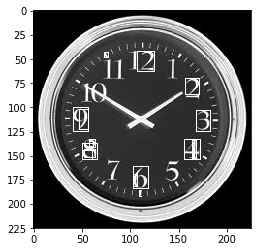

In [58]:
# top 20 matched kp
good_matched_kp = sorted(macthed_kp_map.keys(), key=lambda x: min([dmatch.distance for dmatch in macthed_kp_map[x]]))[:20]
candidate_bb = filter_contours_by_kp(hay_img, contours, good_matched_kp)
draw_contour_bb(hay_img, None, candidate_bb, 255)

In [59]:
# merge bb
# return positive number if there's overlap, o/w return negative number of their distance
def overlap_bw_segment(line1, line2):
    a1, a2 = line1
    b1, b2 = line2
    if a2 <= b1:
        return a2 - b1
    if a1 >= b2:
        return b2 - a1
    return min(a2, b2) - max(a1, b1)

def decide_merge(bb1, bb2, overlap_ratio):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    x_overlap = overlap_bw_segment((x1, x1+w1), (x2, x2+w2))
    y_overlap = overlap_bw_segment((y1, y1+h1), (y2, y2+h2))
    x_ratio = x_overlap*1.0 / min(w1, w2)
    y_ratio = y_overlap*1.0/ min(h1, h2)
    return min(x_ratio, y_ratio) >= -(1 - overlap_ratio) and max(x_ratio, y_ratio) >= overlap_ratio

def merge_two_bb(bb1, bb2):
    x1, y1, w1, h1 = bb1
    x2, y2, w2, h2 = bb2
    new_x = min(x1, x2)
    new_y = min(y1, y2)
    new_w = max(x1 + w1, x2 + w2) - new_x
    new_h = max(y1 + h1, y2 + h2) - new_y
    return new_x, new_y, new_w, new_h
    
def merge_bb(bb_list, overlap_ratio=0.6):
    new_bb_list = []
    while True:
        merged_idx = set()
        new_bb_list = []
        for i in range(len(bb_list)):
            if i in merged_idx: continue
            for j in range(i+1, len(bb_list)):
                if j in merged_idx: continue
                if decide_merge(bb_list[i], bb_list[j], overlap_ratio):
                    merged_idx.add(i)
                    merged_idx.add(j)
                    new_bb_list.append(merge_two_bb(bb_list[i], bb_list[j]))
                    break
        if not new_bb_list: break
        bb_list = [bb_list[i] for i in range(len(bb_list)) if i not in merged_idx] + new_bb_list
    return bb_list

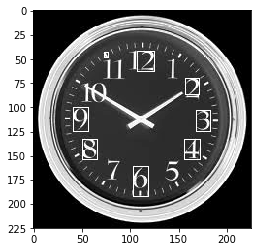

In [60]:
merged_candidate_bb = merge_bb(candidate_bb)
draw_contour_bb(hay_img, None, merged_candidate_bb, 255)

In [61]:
from torch import load

from image_util import *
model = load('vanilla_extra/epoch_25.pkl')

In [64]:
merged_candidate_bb.append((103, 161, 16, 21))

In [65]:
for bb in merged_candidate_bb:
    x, y, w, h = bb
    tensor = cv2tensor(hay_img[y:y+h, x:x+w])
    prob = predict_image(tensor, model)[0]
    if max(prob) > 0.9:
        print(max(prob))
        print('high probability for {} predicted as {}'.format(bb, np.argmax(prob)))

0.9999999
high probability for (107, 42, 18, 21) predicted as 2
0.9999999
high probability for (168, 103, 15, 22) predicted as 3
1.0
high probability for (41, 100, 16, 25) predicted as 9
1.0
high probability for (156, 133, 16, 21) predicted as 4
0.9872194
high probability for (103, 161, 16, 31) predicted as 0
1.0
high probability for (51, 133, 15, 21) predicted as 8
1.0
high probability for (103, 161, 16, 21) predicted as 6


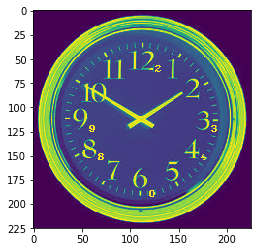

In [63]:
def draw_prediction(model, image, bb_list):
    hay_img = np.copy(image)
    for bb in bb_list:
        x, y, w, h = bb
        tensor = cv2tensor(hay_img[y:y+h, x:x+w])
        prob = predict_image(tensor, model)[0]
        if max(prob) > 0.9:
            text = '{}'.format(np.argmax(prob))
            cv2.putText(hay_img, text, (x+w, y+h), cv2.FONT_HERSHEY_COMPLEX_SMALL, 0.5, (255, 255, 255))
    plt.imshow(hay_img)
draw_prediction(model, hay_img, merged_candidate_bb)

## shape context not working well

In [296]:
from shape_context import ShapeContext
sc = ShapeContext()
def compute_distance(sc, img1, img2):
    pts1 = sc.get_points_from_img(img1, simpleto=100)
    descriptor1 = sc.compute(pts1)#.flatten()
    pts2 = sc.get_points_from_img(img2, simpleto=100)
    descriptor2 = sc.compute(pts2)#.flatten()
    return sc.diff(
#         np.reshape(descriptor1, (len(descriptor1), 1)),
#         np.reshape(descriptor2, (len(descriptor1), 1)),
#         50
        descriptor1, descriptor2
    )

def find_match(hay_img, bbs, needle_img):
    min_dist, bb = 2**31, None
    for x, y, w, h in bbs:
        croped = hay_img[y:y+h, x:x+w]
        dist, _ = compute_distance(sc, croped, needle_img)
        print(dist)
        if dist < min_dist:
            min_dist, bb = dist, (x, y, w, h)
    return bb

65.5736246027
35.6258308127
57.3028278334
31.0458642792
48.1845799551
53.2568323574
43.9405744189
40.0565726008
49.995684918
39.2643626865


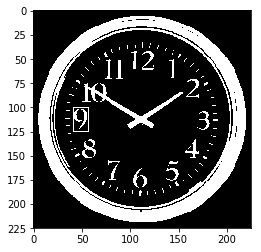

In [297]:
_,hay_img = cv2.threshold(hay_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
_,needle_img = cv2.threshold(needle_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

final_bb = find_match(hay_img, merged_candidate_bb, needle_img)
draw_contour_bb(hay_img, None, [final_bb], 255)

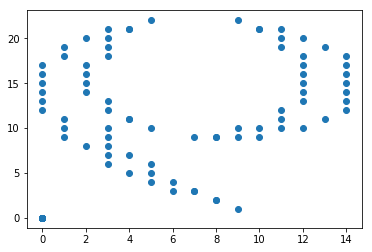

In [306]:
x, y, w, h = merged_candidate_bb[1]
croped = hay_img[y:y+h, x:x+w]
ret2,croped = cv2.threshold(croped,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

pts1 = sc.get_points_from_img(croped, simpleto=500)
xs, ys = zip(*pts1)
plt.scatter(xs, ys)

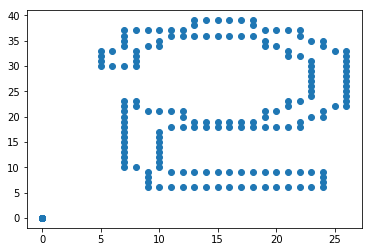

In [307]:
pts2 = sc.get_points_from_img(needle_img, simpleto=500)
xs, ys = zip(*pts2)
plt.scatter(xs, ys)

In [300]:
cnts[2]

array([[[-1, -1, -1, -1]]], dtype=int32)

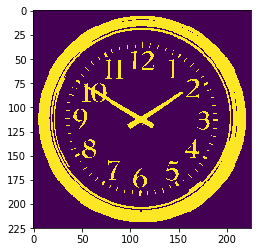

In [301]:
plt.imshow(croped)

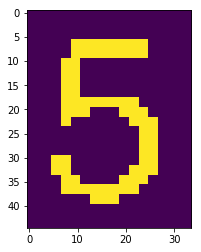

In [302]:
ret2,needle_out = cv2.threshold(needle_img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
plt.imshow(needle_out)

In [303]:
pts1 = sc.get_points_from_img(needle_img, simpleto=50)
descriptor1 = sc.compute(pts1).flatten()
x, _ = np.reshape(descriptor1, (len(descriptor1), 1)).shape